# RAMP Starting Kit on Shape and Patterns classification challenge

## Group 23

*Céline DEIVANAYAGAM,
Najlaa SRIFI,
Amal MESSAI,
Wendy SAN,
Ibtissam ZADOUANI,
Sami BOUMAIZA*



<br>
<br>



<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 40%;">
        <a href="https://ramp.studio/">
            <img src="img/ramp_logo.png" width="350px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 40%;">
        <a href="https://roboflow.com/">
            <img src="https://www.blacksintechnology.net/wp-content/uploads/job-manager-uploads/company_logo/2021/04/roboflow_full_logo_default-2.png" width="350px"/>
        </a>
    </td>
  </tr>
 </table>
</div>

# Introduction

In the dynamic world of robotics, the integration of cutting-edge sensing and perception technologies is crucial for unlocking new capabilities and functionalities. Whether navigating complex environments or interacting with objects, the ability to recognize shapes empowers robots to make intelligent decisions and perform tasks with accuracy.

To address these challenges, we aim to explore the potential of AI-image recognition using the geometric shape dataset, ShapeDetector.
This dataset comprises 13 distinct geometric shapes, including circles, hexagons, rectangles, and more, as illustrated below.

The objective of this challenge is to develop machine learning models capable of accurately classifying these geometric shapes. By leveraging the ShapeDetector dataset, we seek to advance the field of robotics and pave the way for enhanced perception and decision-making capabilities in robotic systems.

Another aspect of this challenge involves exploring possibilities for data augmentation. This process enhances the dataset by introducing variations to the images, such as adding noise, blurring, displacement, and rotation.
 By augmenting the data in this way, we can improve the robustness and generalization ability of machine learning models trained on the dataset.


For more information on ShapeDetector and its elements, please visit: [https://universe.roboflow.com/mflyyoloseg/shapedetector]

Let's embark on this journey together to unlock the potential of AI-image recognition in shaping the future of robotics!



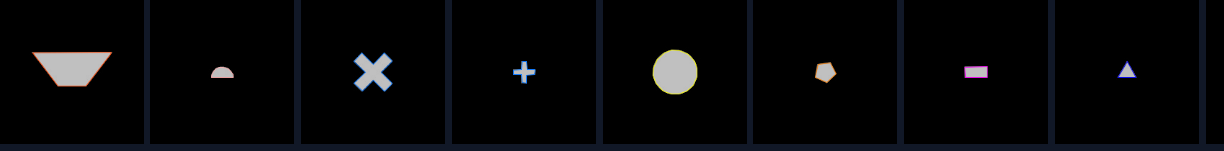



# Table of contents
1. [Import data](#Import_data)
    
2. [Data Exploration](#data_exp)
    1. [Surface area distribution](#sad)
    2. [Mean image](#2)
    3. [Symmetry](#3)
    4. [Perimeter](#4)
    5. [Kmeans](#5)

3. [Data Augumentation](#Data_Aug)
    1. [Adding some blurring](#6)
    2. [Adding some noise](#7)
    3. [A way to deblur images](#8)
    4. [Rotate the image](#9)
    5. [Move the image](#10)
    6. [Classe ImageK](#11)
    
4. [Basic Classifier](#classifier)
5. [Submission](#Submission)

## Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
import random
import itertools as it
import functools

# 1. Import Data <a class="anchor" id="Import Data"></a>
Data consist of  grey-scale images of geometric shapes with a total of 13 target labels.


In [2]:
import zipfile
# Open the zip file
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    # Extract all the contents
    zip_ref.extractall()

In [3]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_train = np.array(pd.read_csv("data/y_train.csv")['y_train'])
y_test = np.array(pd.read_csv("data/y_test.csv")['y_test'])

In [4]:
# Read csv
train_df = pd.read_csv("data/train/_classes.csv", sep=', ', engine="python")

# Mapping int to categories
CLASSES = train_df.columns[1:]
CLASSES_INT = np.arange(len(CLASSES))
cat_to_int = dict(list(zip(CLASSES,CLASSES_INT)))
int_to_cat = dict(list(zip(CLASSES_INT,CLASSES)))
cat_to_int

{'circle': 0,
 'cross': 1,
 'heptagon': 2,
 'hexagon': 3,
 'octagon': 4,
 'pentagon': 5,
 'quartercircle': 6,
 'rectangle': 7,
 'semicircle': 8,
 'square': 9,
 'star': 10,
 'trapezoid': 11,
 'triangle': 12}

Now we can work with `X_train` and `y_train`.



# 2.  Data exploration <a name=data_exp></a>
We propose several approaches to explore the data, like surface area distribution, symmetry, uniformity, and kmeans representation.


### 2.1 Surface area distribution <a class="anchor" id="sad"></a> [↑](#Table-of-contents)


In [5]:
# Number of white pixels of each image
white_pixels = np.sum(X_train != 0,axis=(1,2))

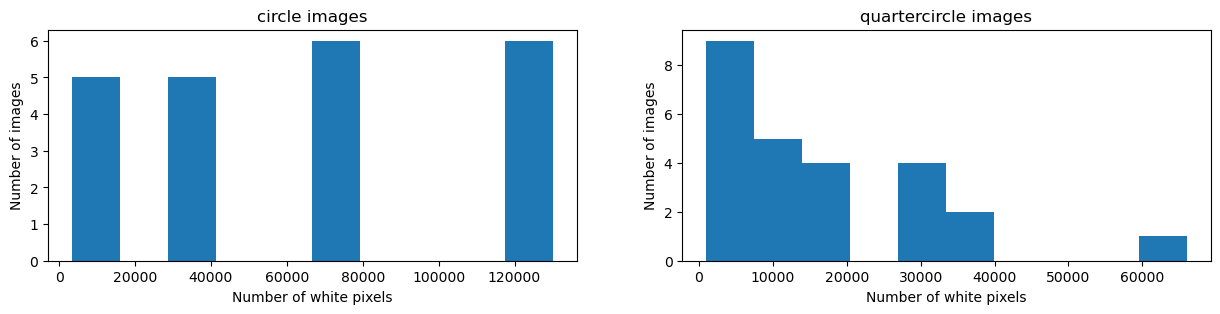

In [6]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

fig, ax = plt.subplots(1,2,figsize=(15, 3))
ax[0].hist(white_pixels[select1])
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[0].set_xlabel("Number of white pixels")
ax[0].set_ylabel("Number of images")

ax[1].hist(white_pixels[select2])
ax[1].set_title(f'{int_to_cat[cat2]} images')
ax[1].set_xlabel("Number of white pixels")
ax[1].set_ylabel("Number of images")

plt.show()

For example, we verify that circles have four times more surface area than quarter-circles, to within normalization.

### 2.2 Mean image <a class="anchor" id="2"></a> [↑](#Table-of-contents)

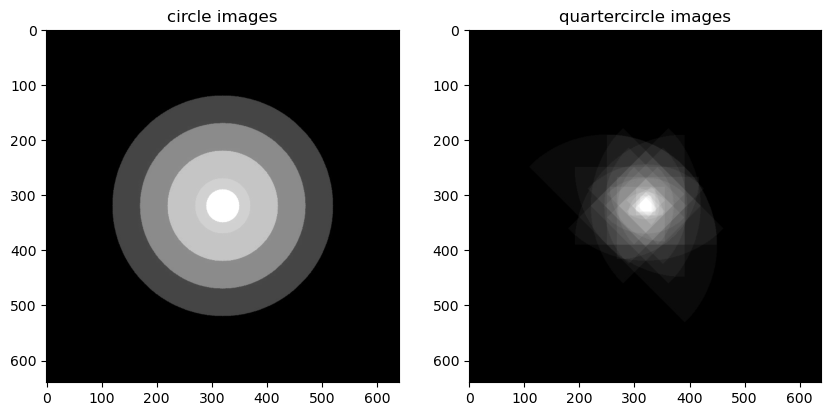

In [8]:
cat1 = cat_to_int['circle']
cat2 = cat_to_int['quartercircle']

select1 = y_train == cat1
select2 = y_train == cat2

mean_img1 = X_train[select1].mean(axis=0)
mean_img2 = X_train[select2].mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(mean_img1, cmap='gray')
ax[0].set_title(f'{int_to_cat[cat1]} images')
ax[1].imshow(mean_img2, cmap='gray')
ax[1].set_title(f'{int_to_cat[cat2]} images')
plt.show()

In order to obtain a relevant average image, the images need to be normalized and rotated.

### 2.3 Symmetry <a class="anchor" id="3"></a> [↑](#Table-of-contents)

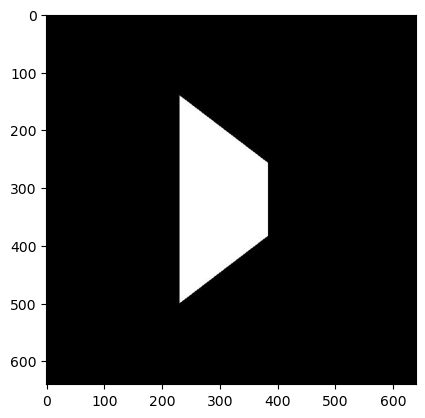

In [10]:
index = 3
Z = X_train[index]
plt.imshow(Z, cmap='gray')

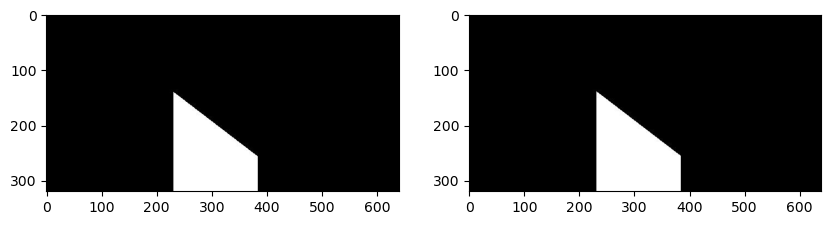

In [11]:
up, down = np.split(Z,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray')
ax[1].imshow(np.flip(down,0), cmap='gray')
plt.show()

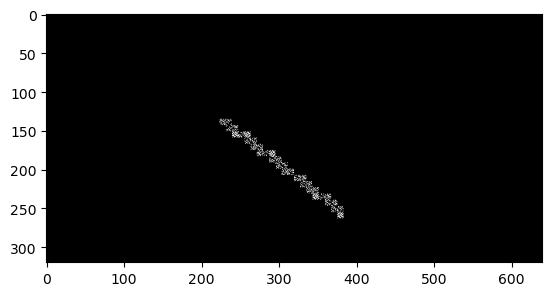

In [12]:
# Difference of the two parts
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

We verify that the image is horizontally symetric, since the difference of the two parts is almost null.

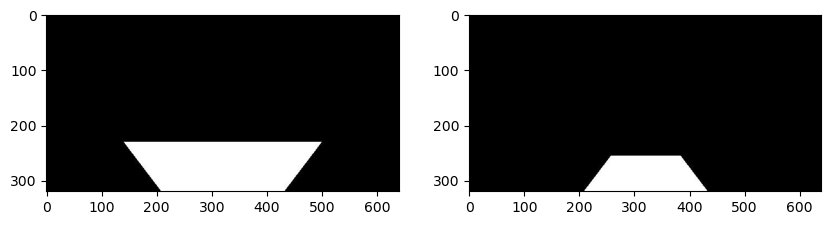

In [13]:
up, down = np.split(Z.T,2)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(up, cmap='gray')
ax[1].imshow(np.flip(down,0), cmap='gray')
plt.show()

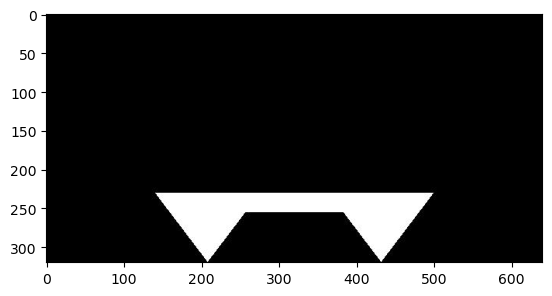

In [14]:
plt.imshow(np.abs(up - np.flip(down,0)), cmap='gray')

However the image is not vertically symetric

## 2.4 Perimeter <a class="anchor" id="4"></a> [↑](#Table-of-contents)

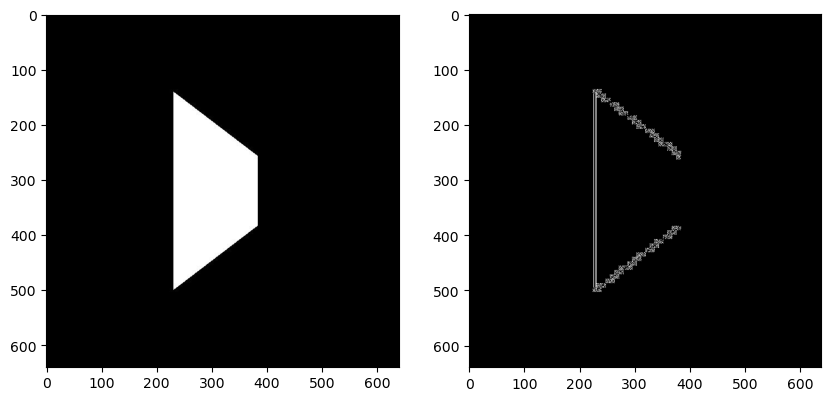

In [16]:
index = 3

Z = X_train[index]
Z_perimeter = np.diff(Z)
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[1].imshow(Z_perimeter, cmap='gray')
plt.show()

Like the surface, the perimeter of the shape could be a metric that define the shape, to within normalization.

## 2.5 Kmeans <a class="anchor" id="5"></a> [↑](#Table-of-contents)

In [18]:
# Pour faire du kmeans
from sklearn.cluster import KMeans

def kmeans(X,K=4):

    kmeansX = KMeans(n_clusters=K,max_iter=10).fit(X)
    label = kmeansX.labels_
    center = kmeansX.cluster_centers_
    res = center[kmeansX.labels_]

    return (res,label,center)

We perform kmeans on each row (and column) of the image. This gives us a kind of convolution:

The image is summarized in K types of bands available in `center`, whose label is stored in `label`. The final image can be accessed through `res`.

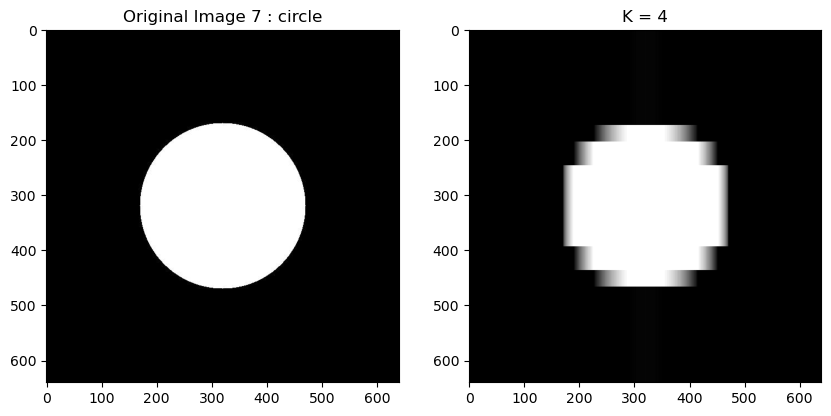

In [19]:
index = 7
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the image
Z = X_train[index]
# Get the category
cat = y_train[index]

if transpose:
    Z = np.transpose(Z)

res,label,center = kmeans(Z,K)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray')
ax[1].set_title(f'K = {K}')
plt.show()

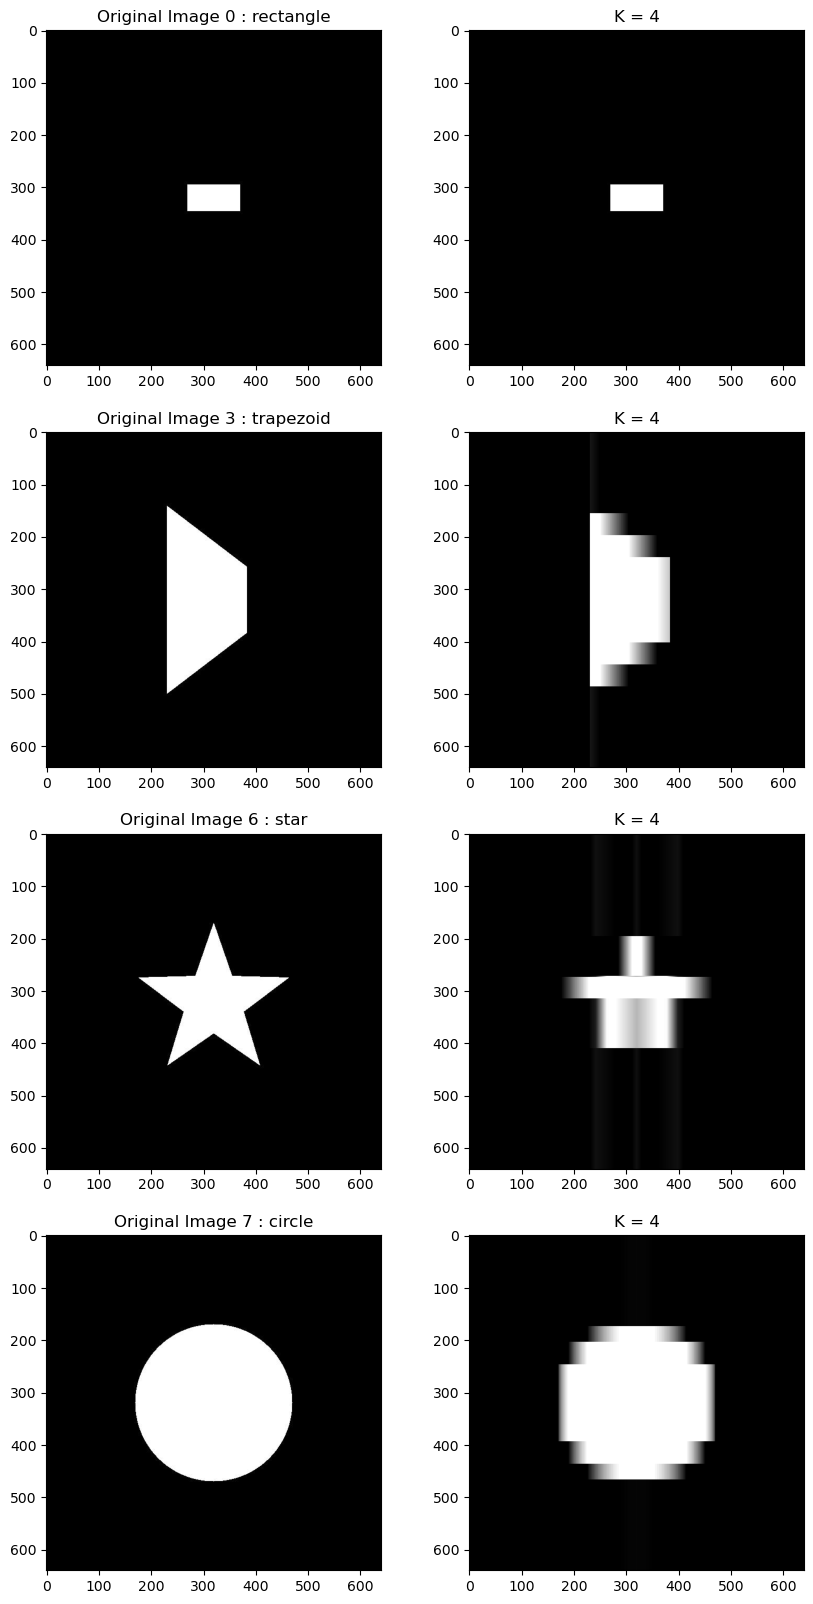

In [20]:
indexes = [0,3,6,7]
n_indexes = len(indexes)
K = 4 # Nombre de patternes autorisés
transpose = False # transpose l'image

# Get the images
Z_selected = X_train[indexes]

fig, ax = plt.subplots(n_indexes,2,figsize=(10, n_indexes*5))

for i,index in enumerate(indexes):

    # Get the image
    Z = X_train[index]
    # Get the category
    cat = y_train[index]

    if transpose:
        Z = np.transpose(Z)

    res,label,center = kmeans(Z,K)

    ax[i,0].imshow(Z, cmap='gray')
    ax[i,0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
    ax[i,1].imshow(res, cmap='gray')
    ax[i,1].set_title(f'K = {K}')

plt.show()

Applying Kmeans gives us several interesting metrics:
- Comparison of Kmeans to the base image. For example, a star is extremely distorted even for a large K
- Comparison of bands with each other. For example, a square or rectangle is very homogeneous.
- Comparison of bands between categories. Bands can then be used to summarize the image. Indeed, it makes sense to reduce image size (640*640 for not that much information...).

# 3. Data Augumentation <a class="anchor" id="Data_aug"></a>
As the test data has only 63 images, proceeding with data augumenatation will help with stronger more robust classification results.
In this section we proceed with some suggetions of data augumentation techniques.

### 3.1 Adding some blurring <a class="anchor" id="6"></a> [↑](#Table-of-contents)

In [22]:
from PIL import Image, ImageFilter

def blur_image(img, radius=2):
    """
    Blur the input image and save the result to the output path.

    Args:
    img (PIL.Image): Input image.
    radius (int): Blur radius. Higher values result in more blurring.

    Returns:
    PIL.Image: Blurred image.
    """
    # Apply the blur filter
    blurred_image = img.filter(ImageFilter.GaussianBlur(radius))

    return blurred_image

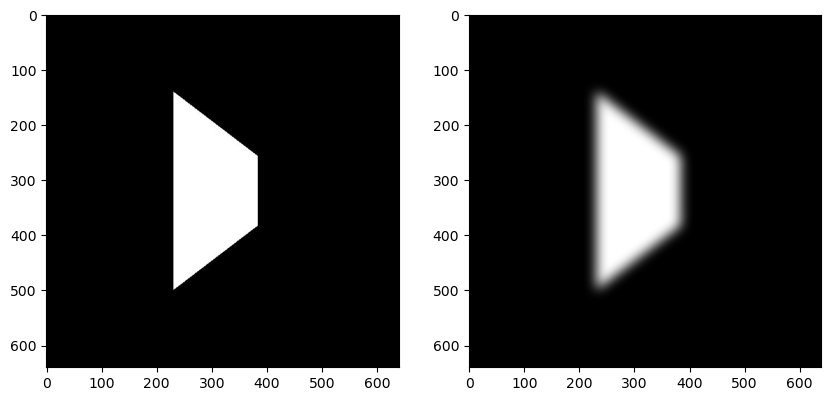

In [23]:
index = 3
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# You can also go back to np array representation with np.array(img)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(blurred_img, cmap='gray')
plt.show()

Blurring the image could counteract naive classification methods.

### 3.2 Adding some noise <a class="anchor" id="7"></a> [↑](#Table-of-contents)


In [25]:
def add_noise(image, mean=0, std_dev=1):
    """
    Add Gaussian noise to the given image.

    Args:
    image (PIL.Image): Input image.
    mean (float): Mean of the Gaussian noise distribution.
    std_dev (float): Standard deviation of the Gaussian noise distribution.

    Returns:
    PIL.Image: Image with added Gaussian noise.
    """
    # Convert image to numpy array
    img_array = np.array(image)

    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, img_array.shape).astype(np.uint8)

    # Add noise to the image
    noisy_image = np.clip(img_array + noise, 0, 255).astype(np.uint8)

    # Convert back to PIL image
    noisy_image = Image.fromarray(noisy_image)

    return noisy_image

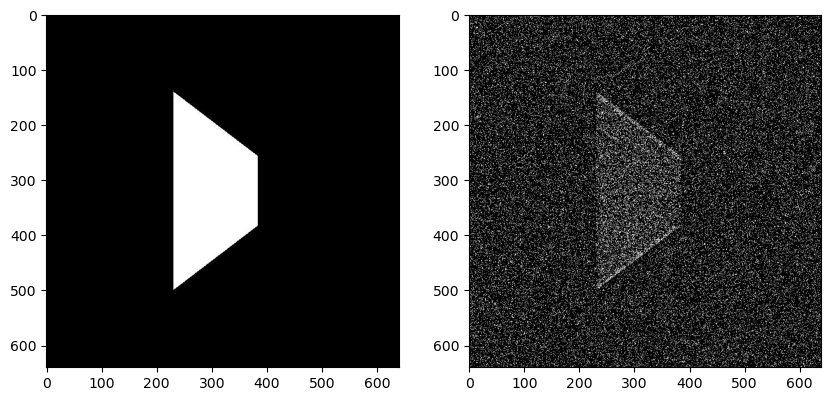

In [26]:
index = 3
mean_noise = 5
std_dev_noise = 5

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
noisy_img = add_noise(img,mean_noise,std_dev_noise)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(noisy_img, cmap='gray')
plt.show()

Adding noise can make the task very difficult.
With a little noise, the Kmeans transformation is able to recognize the image (mean=0, std=1).

### 3.3 A way to deblur images <a class="anchor" id="8"></a> [↑](#Table-of-contents)

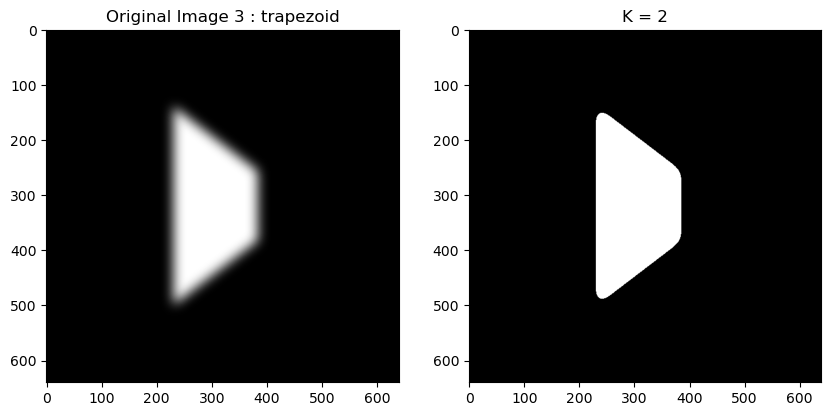

In [28]:
index = 3
K = 2 # Nombre de patternes autorisés
radius = 10
transpose = False # transpose l'image

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

# Get the image
if transpose:
    Z = np.array(blurred_img).T.ravel().reshape(-1,1)
else:
    Z = np.array(blurred_img).ravel().reshape(-1,1)

# Get the category
cat = y_train[index]

res,label,center = kmeans(Z,K)

Z = Z.reshape(640,640)
res = res.reshape(640,640)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(Z, cmap='gray')
ax[0].set_title(f'Original Image {index} : {int_to_cat[cat]}')
ax[1].imshow(res, cmap='gray')
ax[1].set_title(f'K = {K}')
plt.show()

Here we've done Kmeans not on the rows, not on the columns, but on the whole image. We use K=2 because the images are all black and white.

We can overcome blurring with Kmeans, and it's a very good way of summarizing the image.

### 3.4 Rotate the image <a class="anchor" id="9"></a> [↑](#Table-of-contents)

In [30]:
def rotate_image(image, angle):
    """
    Rotate the input image by the specified angle.

    Args:
    image (PIL.Image): Input image.
    angle (float): Angle of rotation in degrees.

    Returns:
    PIL.Image: Rotated image as a NumPy array.
    """
    # Rotate the image
    rotated_image = image.rotate(angle, expand=False)

    return rotated_image

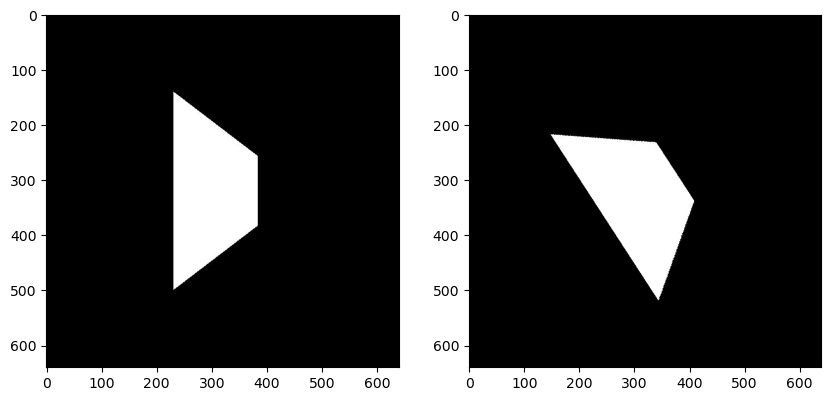

In [31]:
index = 3
angle = 33

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
rotated_image = rotate_image(img,angle)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(rotated_image, cmap='gray')
plt.show()

This code rotates the images. This can be used to add difficulty, or to help the user classify images.

### 3.5 Move the image <a class="anchor" id="10"></a> [↑](#Table-of-contents)

In [33]:
def move_image(image, x, y):
    """
    Move the input image by the specified displacements in the x and y directions.

    Args:
    image (PIL.Image): Input image.
    output_image_path (str): Path to save the moved image.
    x (int): Displacement in the x direction.
    y (int): Displacement in the y direction.
    """
    # Move the image
    moved_image = Image.new("RGB", image.size)
    moved_image.paste(image, (x, y))

    return moved_image

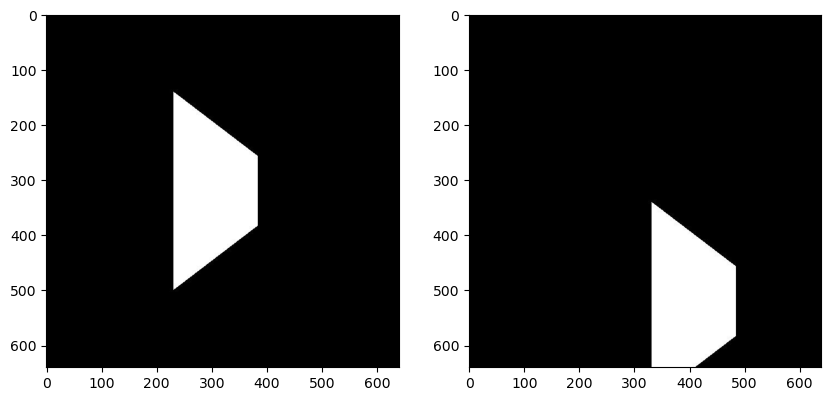

In [34]:
index = 3
x_move = 100
y_move = 200

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
moved_img = move_image(img,x_move,y_move)

fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].imshow(img, cmap='gray') # PIL Images are compatible with matplotlib
ax[1].imshow(moved_img, cmap='gray')
plt.show()

This code moves the images. This can be used to add difficulty, as we could even crop the image.

### 3.6 Classe ImageK <a class="anchor" id="11"></a> [↑](#Table-of-contents)

We summarize some of the features explored through the `ImageK` class.

An image is defined as the set of parameters :
- `K` (the number of labels)
- `res` (the image after kmeans, i.e. the vector of all bands)
- `label` (the vector of labels in each band)
- `center` (the vector of K bands)
- `ass` (a horizontal asymmetry factor, i.e. on lattitude)
- and similarly via the transpose (hence `assT` vertical asymmetry, for example)

In [36]:
class ImageK():
    def __init__(self,original,K=2,length=640,height=640):
        self.original = original.reshape(length,height)
        self.K = K
        self.length = length
        self.height = height
        self.res, self.label, self.center = kmeans(self.original.reshape(-1,1),K)
        self.res = self.res.reshape(length,height)

        # Asymétrie lattidudinale
        up, down = np.split(self.res,2)
        self.ass = np.abs(up-np.flip(down,0)).mean()

        # Asymétrie longitudinale
        up, down = np.split(self.res.T,2)
        self.assT = np.abs(up-np.flip(down,0)).mean()

        return

In [37]:
index = 5
K = 2 # Nombre de patternes autorisés
radius = 10

img = X_train[index]
img = Image.fromarray(img) # convert img to PIL Image
blurred_img = blur_image(img,radius)

img = np.array(img)
blurred_img = np.array(blurred_img)

In [38]:
a = ImageK(blurred_img,K)

Horizontal asymmetry factor

In [39]:
a.ass

0.128536810481398

Vertical asymmetry factor

In [40]:
a.assT

9.518150816147523

Blurred image

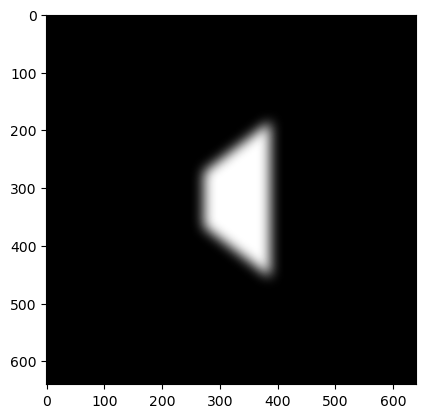

In [41]:
plt.imshow(a.original, cmap='gray')

Kmeans transformation

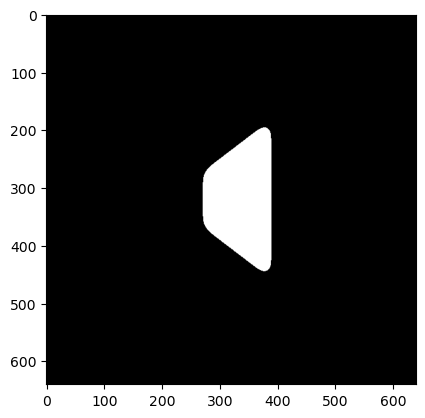

In [42]:
plt.imshow(a.res, cmap='gray')

# 4. Basic Classifier <a class="anchor" id="classifier"></a>


Here, we try a Random Forest classifier.

In [43]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_flat, y_train, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict labels for the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_accuracy)

Accuracy: 0.5079365079365079
Balanced accuracy: 0.49166666666666664


# 5. Submission <a class="anchor" id="submission"></a>


## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [Shape And Patterns](http://www.ramp.studio/events/hotjupiter_datacamp2023). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/hotjupiter_datacamp2023/sandbox) and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/hotjupiter_datacamp2023/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/hotjupiter_datacamp2023/leaderboard)) is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

In [49]:
!ramp-test --submission starting_kit

Testing Shapes and patterns classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
Traceback (most recent call last):

  File "C:\Users\samib\anaconda3\lib\site-packages\rampwf\utils\submission.py", line 121, in train_test_submission
    trained_model = problem.workflow.train_submission(

  File "C:\Users\samib\anaconda3\lib\site-packages\rampwf\workflows\classifier.py", line 22, in train_submission
    clf.fit(X_array[train_is], y_array[train_is])

  File "C:\Users\samib\anaconda3\lib\site-packages\pandas\core\frame.py", line 3511, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]

  File "C:\Users\samib\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 5796, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)

  File "C:\Users\samib\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 5856, in _raise_if_missing
    raise KeyError(f"None 